<a href="https://colab.research.google.com/github/ceydaaseen/HumanActionRecognition/blob/main/Human_Action_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

  if event.key is 'enter':



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

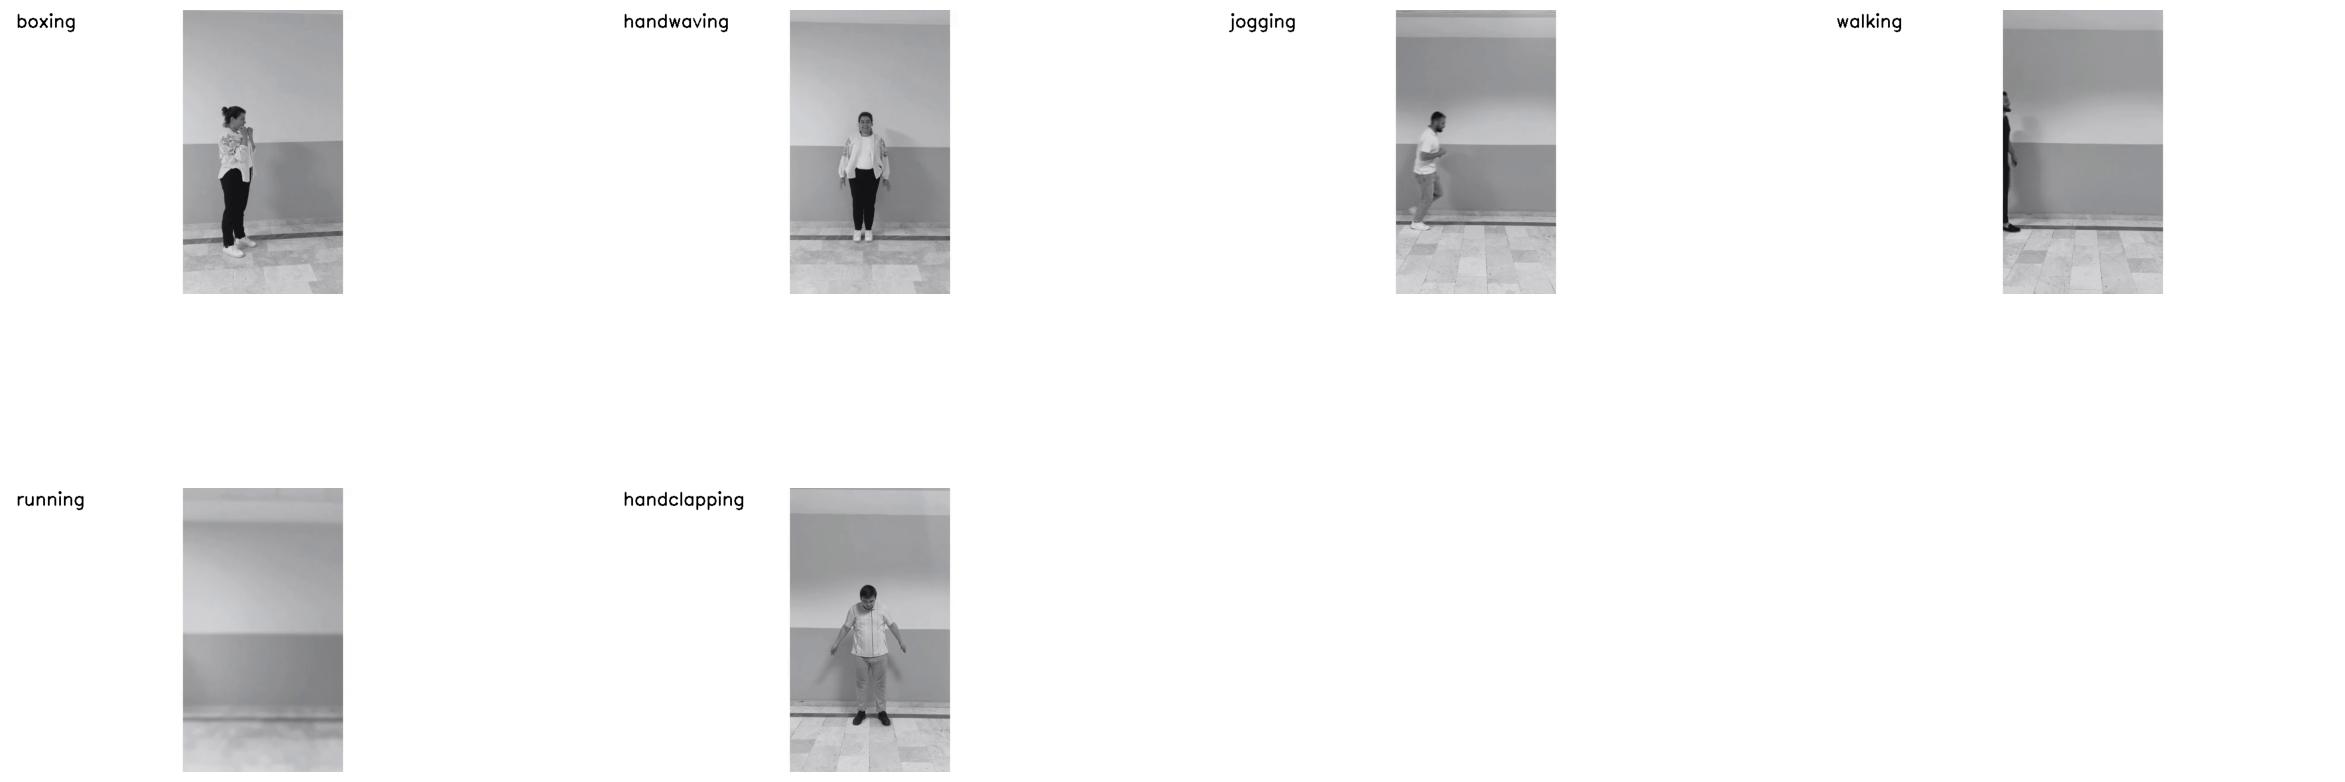

In [ ]:
#veri setinin görseli oluşturuldu, sınıf isimleri verilecek ve random olarak sınıf görüntüleri gelecek.
plt.figure(figsize=(30,30))
dataset_path = '/content/drive/MyDrive/my_har_dataset'
classes_names = ["boxing", "handclapping", "handwaving", "jogging", "running", "walking"]
#sınıflar için klasör yolu belirlenmesi
classes_paths = [os.path.join(dataset_path, cls) for cls in classes_names]
#sınıflara rastgele indeks atama
random_range = random.sample(range(len(classes_paths)),6)

for counter, random_index in enumerate(random_range, 1): #sınıflar için işlemlerin sırasıyla yapılması
  selected_class_name = classes_names[random_index] #rastgele seçilen sınıf isimlerinin alınması
  video_files_names_list = os.listdir(classes_paths[random_index]) #sınıfa ait dosyadaki videoların listelerinin alınması
  selected_video_file_name = random.choice(video_files_names_list) #sınıftan rastgele video seçilmesi
  video_reader = cv2.VideoCapture(os.path.join(classes_paths[random_index], selected_video_file_name)) #seçilen videonun okunması (ilk frame'in gösterilmesi için)

  _, bgr_frame = video_reader.read() #ilk karenin okunması
  video_reader.release()#video dosyasının kapatılması
  #bgr rbg format dönüşümü (opencv - matplotlib)
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
  #görüntülerin sol üst kısmına sınıf ismi yazdırma
  cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
  #görüntünün çizdirilmesi , tek pencere
  plt.subplot(5,4,counter);
  plt.imshow(rgb_frame);
  plt.axis('off')

In [ ]:
image_height, image_width = 64, 64 #alınan kare boyutu
sequence_length = 20 #alınacak frame sayısı
dataset_directory = '/content/drive/MyDrive/my_har_dataset' #veri seti dizin yolu
classes_list = ["walking", "jogging", "handwaving", "handclapping", "boxing", "running"]

In [ ]:
#boyutlandırma ve normalizasyon, listeye dönüşüm
def frames_extraction(video_path):
  frames_list = []
   video_reader = cv2.VideoCapture(video_path) #opencv ile video dosyalarının açılması
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) #alınan toplam frame sayısı
  skip_frames_window = max(int(video_frames_count/sequence_length), 1) #toplam frame sayısı / istenen frame sayısı (kaçıncı frame'in alınacağı belirlenir)

  for frame_counter in range(sequence_length): #istenen aralıktaki (20) karelerin alınması
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window) #set() ile doğrudan belirli bir kareye gidilmesi
    success, frame = video_reader.read() #frame okunması

    if not success:
      break #video sonuna gelindiyse döngüden çıkılır
    resized_frame = cv2.resize(frame, (image_height, image_width)) #alınan kare boyutuna dönştürülmesi
    normalized_frame = resized_frame / 255 #0-1 aralığında normalizasyon (piksel değerleri için) yapılması, işlemlerin hızlanması için
    frames_list.append(normalized_frame) #hazırlanan frame'i listeye ekleme
  video_reader.release() #video dosyasının kapatılması
  return frames_list

In [ ]:
#veri seti oluşturumu
def create_dataset():
  features=[]
  labels=[]
  video_files_paths=[]

  for class_index, class_name in enumerate(classes_list): #her sınıf için döngünün başlatılması, enumarate ile hem indeks hem isim alınması sağlanır
    print(f'Extracting Data of class: {class_name}')
    files_list = os.listdir(os.path.join(dataset_directory, class_name)) #tüm video dosyalarının listelenmesi
    for file_name in files_list: #her video için tam yol oluşturulması
      video_file_path = os.path.join(dataset_directory, class_name, file_name)
      frames = frames_extraction(video_file_path) #video dosyasından 20 frame'in çıkarılması ve işlenmesi
      if len(frames) == sequence_length:
        features.append(frames) #features'a frame dizisi eklenir
        labels.append(class_index) #sınıf inseksi labels'a eklenir
        video_files_paths.append(video_file_path) #video dosya yolu eklenir

  features = np.asarray(features) #liste verileri numpy dizisine dönüştürülür
  labels = np.array(labels)
  return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of class: walking
Extracting Data of class: jogging
Extracting Data of class: handwaving
Extracting Data of class: handclapping
Extracting Data of class: boxing
Extracting Data of class: running


In [ ]:
one_hot_encoded_labels = to_categorical(labels) #format dönüşümü

In [ ]:
# train test = 0.3 - 0.7 olarak verilmişti, deneme 0.2-0.8 şeklinde yapılacak.
#random_state sonuçlar çalıştırıldığında aynı olacak (seed_constant ile)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2,
                                                                            shuffle = True, random_state = seed_constant)

In [ ]:
def create_convlstm_model():
  model = Sequential()  #katmanlar sırasıyla eklenecek, sıralı model oluşumu
  #1. convlstm katmanı, 4 filtreli 3x3'lük convlstm katmanı
  #return_sequences: sonraki katmanın zaman serisi bekleme durumu
  #ezberleme önlemek için dropout uygulandı
  #input shape: 20 frame 64x64 rgb video girdisi
  model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                       recurrent_dropout=0.3, return_sequences=True, input_shape = (sequence_length,image_height, image_width, 3)))
  #havuzlama için max-poolig her framede 2x2 filtre
  #ezberleme olmaması için her zaman dropout uygulaması
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  #8 filtreli 3x3 cnvlstm katmanı
  model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                       recurrent_dropout=0.3, return_sequences=True))
  #havuzlama her adımda 2x2'lik filtre
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                       recurrent_dropout=0.3, return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                       recurrent_dropout=0.3, return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  #matris vektör dönüşümünün flattening layer'da gerçekleştirilmesi
  model.add(Flatten())
  #liste uzunluğu kadar nöronlu ysa
  model.add(Dense(len(classes_list), activation = "softmax"))
  model.summary()
  return model



In [ ]:
convlstm_model = create_convlstm_model()
print("Model Created Successfully!")
#model görselleştirildi

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 20, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 3, 3, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        17,286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,286 (196.43 KB)

 Trainable params: 50,286 (196.43 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


In [ ]:
#optimizasyon algoritması Adam,batch_size=16 , 100 epoch, patience=90, min kayıp bekleniyor
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 90, mode = 'min', restore_best_weights = True)
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 16 ,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - accuracy: 0.2351 - loss: 1.7798 - val_accuracy: 0.1364 - val_loss: 1.7715
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.1955 - loss: 1.7621 - val_accuracy: 0.1364 - val_loss: 1.7314
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - accuracy: 0.2356 - loss: 1.6860 - val_accuracy: 0.3068 - val_loss: 1.5273
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - accuracy: 0.2758 - loss: 1.4626 - val_accuracy: 0.4432 - val_loss: 1.1957
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - accuracy: 0.4115 - loss: 1.2112 - val_accuracy: 0.3864 - val_loss: 1.1498
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.4082 - loss: 1.0971 - val_accuracy: 0.4205 - val_loss: 1.0632
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.4317 - loss: 1.0423 - val_accuracy: 0.4659 - val_loss: 1.0391
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.5192 - loss: 0.9947 - val_accuracy: 0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step
Sınıflandırma Raporu:

              precision    recall  f1-score   support

     walking       1.00      0.38      0.56        13
     jogging       0.38      0.38      0.38        13
  handwaving       0.96      0.90      0.93        29
handclapping       0.82      0.95      0.88        19
      boxing       0.96      0.96      0.96        24
     running       0.40      0.62      0.48        13

    accuracy                           0.77       111
   macro avg       0.75      0.70      0.70       111
weighted avg       0.81      0.77      0.77       111



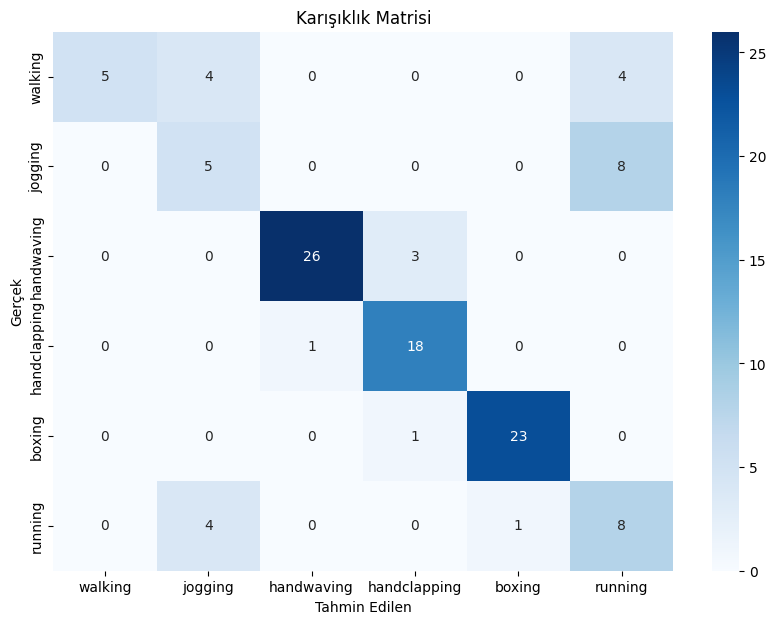

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# test verisi ile tahmin yapılacak
predictions = convlstm_model.predict(features_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(labels_test, axis=1)

classes_list = ["walking", "jogging", "handwaving", "handclapping", "boxing", "running"]

print("Sınıflandırma Raporu:\n")
print(classification_report(true_labels, predicted_labels, target_names=classes_list))

#karmaşıklık matrisi
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=classes_list, yticklabels=classes_list)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Karışıklık Matrisi")
plt.show()

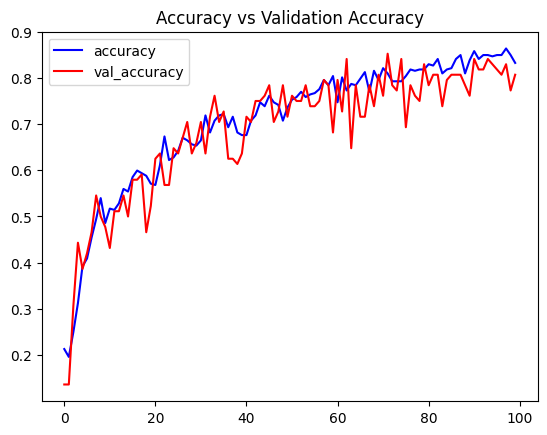

In [ ]:
#doğruluk ve eğitim doğruluk değerleri için grafik oluşturulacak.
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'b', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'r', label = metric_name_2)

    plt.title(plot_name)
    plt.legend()
    plt.show()

plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy','Accuracy vs Validation Accuracy')
